In [1]:
from stop_metrics import create_combined_metrics_stop_df, time_to_next_stop
from trip_metrics import create_combined_metrics_trip_df
from utils import create_trips_df, create_trips_df_pid
import matplotlib.pyplot as plt
import random
import plotly.express as px
import polars as pl
import pandas as pd


In [2]:
def average_by(df:pd.DataFrame, grouping:str, period:str, metrics:list):
    """
    grouping helper function 
    """
    if 'community' in df.columns:
        df = df[['rt','period','period_value', 'community']+metrics]
    else: 
        df = df[['rt','period','period_value']+metrics]
        
    if period == "one_value":
        by_period = df[df['period'] == 'dayofyear']
        by_period_grouped = by_period.groupby([grouping])[metrics].median().reset_index()

    elif period == 2024:
        # only 2024 data
        by_period = df[(df['period'] == 'year') & (df['period_value'] == 2024)] 
        by_period_grouped = by_period.groupby([grouping])[metrics].median().reset_index()

    elif period in df['period'].unique():
        by_period = df[df['period']== period]
        by_period_grouped = by_period.groupby([grouping,'period_value'])[metrics].median().reset_index()
    else:
        print("Invalid period")
        
    #convert to minutes
    for metric in metrics:
        if 'num_buses' not in metric:
            by_period_grouped[metric] = by_period_grouped[metric].dt.total_seconds()/60

    
    return by_period_grouped

In [3]:
def load_metrics():
    """
    Load metrics, combine them, add in community stop crosswalk, and remove weird routes
    """
    #loading data
    ca_xwalk = pl.read_parquet('communities_stops.parquet')
    ca_xwalk = ca_xwalk.select(['community','stpid']).rename({'stpid':'stop_id'})

    actual_stops = pl.read_parquet('out/actual_stop_metrics_df.parquet')
    schedule_stops = pl.read_parquet('out/schedule_stop_metrics_df.parquet')
    actual_trips  = pl.read_parquet('out/actual_trip_metrics_df.parquet')
    schedule_trips = pl.read_parquet('out/schedule_trip_metrics_df.parquet')

    total_stops = create_combined_metrics_stop_df(actual_stops, schedule_stops)
    total_stops = total_stops.join(ca_xwalk, on='stop_id', how = 'left', coalesce=True)

    total_trips = create_combined_metrics_trip_df(actual_trips, schedule_trips)

    # take out weird routes
    total_trips = total_trips.filter(~pl.col('rt').is_in(['5','169']))
    total_stops = total_stops.filter(~pl.col('rt').is_in(['5','169']))

    return total_stops, total_trips

In [25]:
def create_summary_metrics(grouping:str, period:str):
    """
    Load the metrics, average them by a grouping (route:'rt' or community 
    area: 'community_area) and period ('hour','weekday','dayofyear','week',
    'month','year', 'one_value': median of all day metrics, '2024': filter 
    to year and 2024), and return the dataframe
    """


    total_stops, total_trips = load_metrics()
    
    metrics_stop = ['median_actual_time_till_next_bus','std_actual_time_till_next_bus','time_till_next_bus_delay','median_schedule_time_till_next_bus', 'std_schedule_time_till_next_bus',
                'median_schedule_num_buses', 'median_actual_num_buses']
    
    metrics_trip = ['median_actual_trip_duration', 'median_schedule_trip_duration']
    
    if grouping == 'rt':
        avg_stops = average_by(total_stops.to_pandas(),grouping, period, metrics_stop)
        metrics_trip = ['median_actual_trip_duration', 'median_schedule_trip_duration']
        avg_trips = average_by(total_trips.to_pandas(),grouping, period, metrics_trip)
        avg_trips['trip_delay'] = avg_trips['median_actual_trip_duration'] - avg_trips['median_schedule_trip_duration']
        avg_stops['bus_excess'] = avg_stops['median_actual_num_buses'] - avg_stops['median_schedule_num_buses']
        if period in ['one_value',2024]:
            all_metrics_rts = avg_stops.join(avg_trips.set_index(grouping), on=grouping)
        else:   
            all_metrics_rts = avg_stops.join(avg_trips.set_index([grouping,'period_value']), on=[grouping,'period_value'])
        return all_metrics_rts
    
    elif grouping == 'community_area':
        all_metrics_ca = average_by(total_stops.to_pandas(),'community', period, metrics_stop)
        all_metrics_ca['bus_excess'] = all_metrics_ca['median_actual_num_buses'] - all_metrics_ca['median_schedule_num_buses']

        return all_metrics_ca

    


In [30]:
all_metrics_rt_2024 = create_summary_metrics('rt', 2024)
all_metrics_rt_2024.to_csv('out/all_metrics_rt_2024.csv')

In [41]:
#create some tables for the exploration 

all_metrics_rt_month = create_summary_metrics('rt', 'month')
all_metrics_rt_hour = create_summary_metrics('rt', 'hour')
all_metrics_rt_weekday = create_summary_metrics('rt', 'weekday')
all_metrics_rt_year = create_summary_metrics('rt', 'year')

combined = pd.concat([all_metrics_rt_month, all_metrics_rt_hour, all_metrics_rt_weekday, all_metrics_rt_year])


In [43]:
all_metrics_rt_month['period'] = 'month'
all_metrics_rt_hour['period'] = 'hour'
all_metrics_rt_weekday['period'] = 'weekday'
all_metrics_rt_year['period'] = 'year'
combined = pd.concat([all_metrics_rt_month, all_metrics_rt_hour, all_metrics_rt_weekday, all_metrics_rt_year])

In [45]:
combined.to_csv('out/combined_rt.csv')

In [47]:
all_metrics_ca_month = create_summary_metrics('community_area', 'month')
all_metrics_ca_hour = create_summary_metrics('community_area', 'hour')
all_metrics_ca_weekday = create_summary_metrics('community_area', 'weekday')
all_metrics_ca_year = create_summary_metrics('community_area', 'year')

all_metrics_ca_month['period'] = 'month'
all_metrics_ca_hour['period'] = 'hour'
all_metrics_ca_weekday['period'] = 'weekday'
all_metrics_ca_year['period'] = 'year'

combined_ca = pd.concat([all_metrics_ca_month, all_metrics_ca_hour, all_metrics_ca_weekday, all_metrics_ca_year])
combined_ca.to_csv('out/combined_ca.csv')g

In [32]:
all_metrics_ca_2024 = create_summary_metrics('community_area', 2024)
all_metrics_ca_2024.to_csv('out/all_metrics_ca_2024.csv')

In [10]:
def plot_metrics(df:pd.DataFrame, metric:str, grouping:str, time_period:str = None):
    """
    Plots the metrics for the given dataframe
    """
    df = df[[grouping,metric]]
    if not time_period:
        df = df.sort_values(metric, ascending=False)
        fig = px.bar(df, x=grouping, y=metric)
        fig.show()
    else:
        print("Invalid grouping")

    return True

In [12]:
plot_metrics(all_metrics_rt, 'median_actual_time_till_next_bus', 'rt')


True

In [6]:
total_stops, total_trips = load_metrics()

In [17]:
def create_trip_chart(rt):

    #sample of 100 bus trips
    trips = create_trips_df(rt,is_schedule=False)
    pid = trips.group_by('pid').n_unique().sort('trip_id', descending = True).limit(1).rows(named=True)[0]['pid']
    sample_trips = trips.filter(pl.col('pid') == pid).unique(subset=["trip_id"]).sample(100).select(['trip_id'])

    #sample of 100 trips
    trips_100 = trips.filter(pl.col('trip_id').is_in(sample_trips))
    trips_100 = time_to_next_stop(trips_100)
    trips_100 = trips_100.sort(['trip_id','cum_trip_time'], descending=False)


    # get agg values
    agg = total_stops.select(['rt','pid','period','period_value','stop_id', 'median_actual_cum_trip_time','median_schedule_cum_trip_time'])
    agg = agg.filter((pl.col('rt') == rt) & (pl.col('period') == 'year') & (pl.col('period_value') == 2024) & (pl.col('pid') == pid))
    agg = agg.sort('median_actual_cum_trip_time', descending=False)
    # create a fake stop sequence
    agg = agg.with_row_index()

    #chart

    fig, ax = plt.subplots()
    plt.figure(figsize=(10,10))



    for row in trips_100.iter_rows(named=True):
        subset = trips_100.filter(pl.col('trip_id') == row['trip_id'])
        ax.plot(subset['stop_sequence'], subset.select(pl.col('cum_trip_time')).get_columns()[0].dt.total_seconds()/60, color = 'grey', alpha=0.01, linestyle='dashed')

    ax.plot(agg['index'], agg.select(pl.col('median_schedule_cum_trip_time')).get_columns()[0].dt.total_seconds()/60, label = 'Schedule', linewidth=4)
    ax.plot(agg['index'], agg.select(pl.col('median_actual_cum_trip_time')).get_columns()[0].dt.total_seconds()/60, label = 'Real', linewidth=4)

    ax.legend()
    ax.set_xlabel('Stop Sequence')
    ax.set_ylabel('Trip Duration (minutes)')
    plt.show()


{'pid': 14108}
{'pid': 14111}


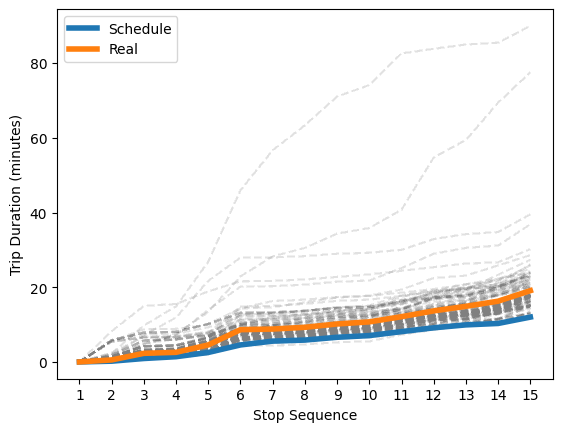

<Figure size 1000x1000 with 0 Axes>

In [40]:
create_trip_chart('171')